In [1]:
! pip install --upgrade cka-pytorch

  Attempting uninstall: cka-pytorch
    Found existing installation: cka-pytorch 0.1.5
    Uninstalling cka-pytorch-0.1.5:
      Successfully uninstalled cka-pytorch-0.1.5


In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.models import resnet18
from tqdm.autonotebook import tqdm
from copy import deepcopy

/var/folders/9t/0nqj876j5299tnv1hzm4vp9r0000gn/T/ipykernel_82695/2226080857.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Setup DataLoader and Models

An important detail is that although we are using the Validation set for `CIFAR10`, we **shuffle** and drop the last batch. This is to ensure that 1) the batches of each epoch are mixed, and 2) each iteration has the same batch size.

In [2]:
transforms = Compose(
    [ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)

dataset = CIFAR10(root="./", train=False, download=True, transform=transforms)
dataloader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
)

In [3]:
model1 = resnet18(pretrained=True).to("mps")
model1.eval()
model2 = deepcopy(model1).to("mps")
model2.eval()
print("Dummy models created")

Dummy models created


/Users/datthinh1801/Code/CKA.pytorch/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/datthinh1801/Code/CKA.pytorch/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Compute CKA

In [4]:
from cka_pytorch import CKACalculator

### Basic Usage

Initializing the `CKACalculator` object will add forward hooks to both `model1` and `model2`.
The default modules that are hooked are: `Bottleneck`, `BasicBlock`, `Conv2d`, `AdaptiveAvgPool2d`, `MaxPool2d`, and all instances of `BatchNorm`.
Note that `Bottleneck` and `BasicBlock` are from the `torchvision` implementation, and will not add hooks to any custom implementations of `Bottleneck/BasicBlock`.

For ResNet18, a total of 50 hooks are added.

By default, the intermediate features are flattened with `flatten_hook_fn` and 10 epochs are run.

In [5]:
model1.named_modules

<bound method Module.named_modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [6]:
calculator = CKACalculator(
    model1=model1,
    model2=model2,
    model1_name="ResNet18",
    model2_name="ResNet18",
    batched_feature_size=256,
    verbose=True,
)

Now we can calculate the CKA matrix

In [7]:
cka_output = calculator.calculate_cka_matrix(dataloader)
print(f"CKA output size: {cka_output.size()}")

Calculate CKA matrix (Epoch 1/10):   0%|          | 0/39 [00:00<?, ?it/s]/Users/datthinh1801/Code/CKA.pytorch/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Calculate CKA matrix (Epoch 10/10): 100%|██████████| 39/39 [00:30<00:00,  1.29it/s]

CKA output size: torch.Size([60, 60])


Extract hooked module names. By default, all layers will be hooked.

In [8]:
for i, name in enumerate(calculator.hook_manager1.module_names):
    print(f"Layer {i}: \t{name}")

Layer 0: 	conv1
Layer 1: 	bn1
Layer 2: 	relu
Layer 3: 	maxpool
Layer 4: 	layer1.0.conv1
Layer 5: 	layer1.0.bn1
Layer 6: 	layer1.0.relu
Layer 7: 	layer1.0.conv2
Layer 8: 	layer1.0.bn2
Layer 9: 	layer1.0
Layer 10: 	layer1.1.conv1
Layer 11: 	layer1.1.bn1
Layer 12: 	layer1.1.relu
Layer 13: 	layer1.1.conv2
Layer 14: 	layer1.1.bn2
Layer 15: 	layer1.1
Layer 16: 	layer2.0.conv1
Layer 17: 	layer2.0.bn1
Layer 18: 	layer2.0.relu
Layer 19: 	layer2.0.conv2
Layer 20: 	layer2.0.bn2
Layer 21: 	layer2.0.downsample.0
Layer 22: 	layer2.0.downsample.1
Layer 23: 	layer2.0
Layer 24: 	layer2.1.conv1
Layer 25: 	layer2.1.bn1
Layer 26: 	layer2.1.relu
Layer 27: 	layer2.1.conv2
Layer 28: 	layer2.1.bn2
Layer 29: 	layer2.1
Layer 30: 	layer3.0.conv1
Layer 31: 	layer3.0.bn1
Layer 32: 	layer3.0.relu
Layer 33: 	layer3.0.conv2
Layer 34: 	layer3.0.bn2
Layer 35: 	layer3.0.downsample.0
Layer 36: 	layer3.0.downsample.1
Layer 37: 	layer3.0
Layer 38: 	layer3.1.conv1
Layer 39: 	layer3.1.bn1
Layer 40: 	layer3.1.relu
Layer 41: 	

#### Visualize the output

Note that the returned matrix has its origin at the top left. In most papers, the CKA matrix is visualized with its origin at the bottom left. Thus, we may flip the matrix first before visualization; however, this example chooses not to.

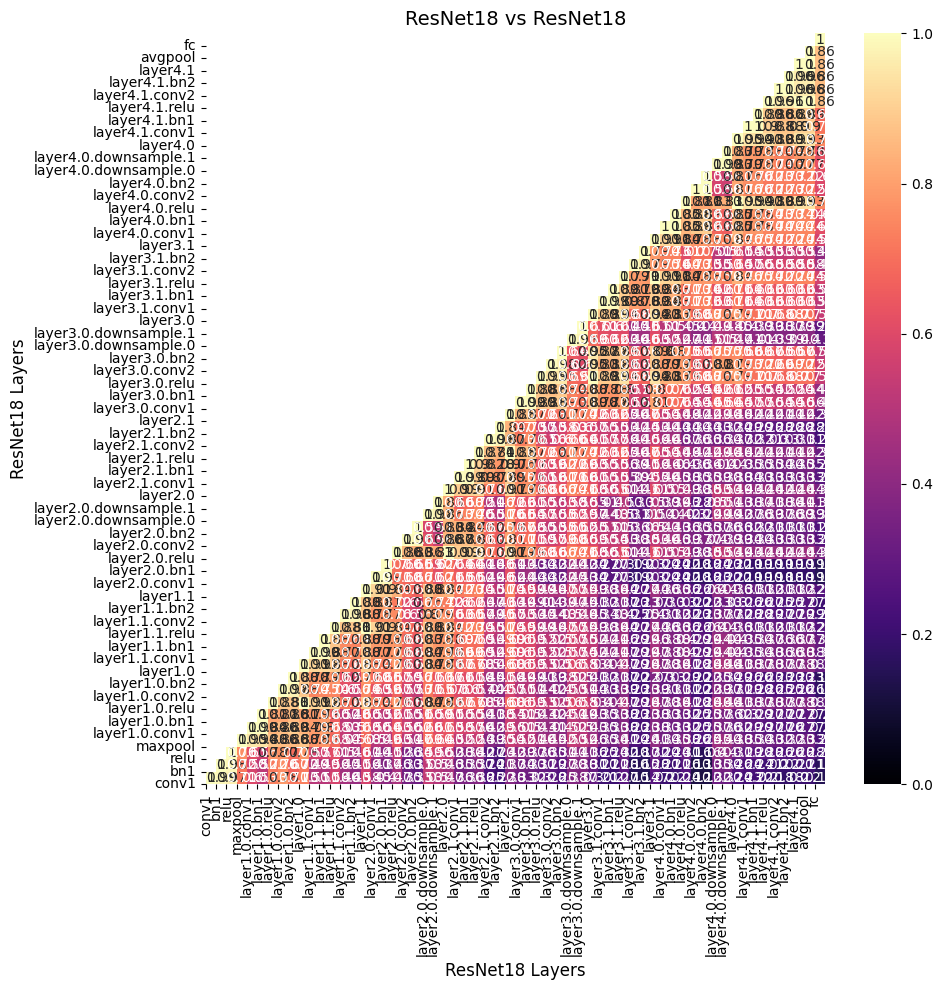

In [9]:
calculator.plot_cka_matrix(
    cka_output,
    show_half_heatmap=True,
    invert_y_axis=True,
    show_annotations=True,
)

### Advanced Usage

We can customize other parameters of the `CKACalculator`.
Most importantly, we can select which modules to hook.

Before instantiating a new instance of `CKACalculator` on, make sure to first call the `reset` method.
This clears all hooks registered in the models.

In [10]:
# Reset calculator to clear hooks
calculator.reset()
torch.cuda.empty_cache()

In [11]:
layers = ["conv1", "bn1"]

In [12]:
calculator = CKACalculator(
    model1=model1,
    model2=model2,
    model1_layers=layers,
    model2_layers=layers,
    model1_name="ResNet18",
    model2_name="ResNet18",
    batched_feature_size=256,
    verbose=True,
)

In [13]:
cka_output = calculator.calculate_cka_matrix(dataloader)

Calculate CKA matrix (Epoch 1/10):   0%|          | 0/39 [00:00<?, ?it/s]/Users/datthinh1801/Code/CKA.pytorch/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Calculate CKA matrix (Epoch 10/10): 100%|██████████| 39/39 [00:27<00:00,  1.44it/s]


#### Visualize output

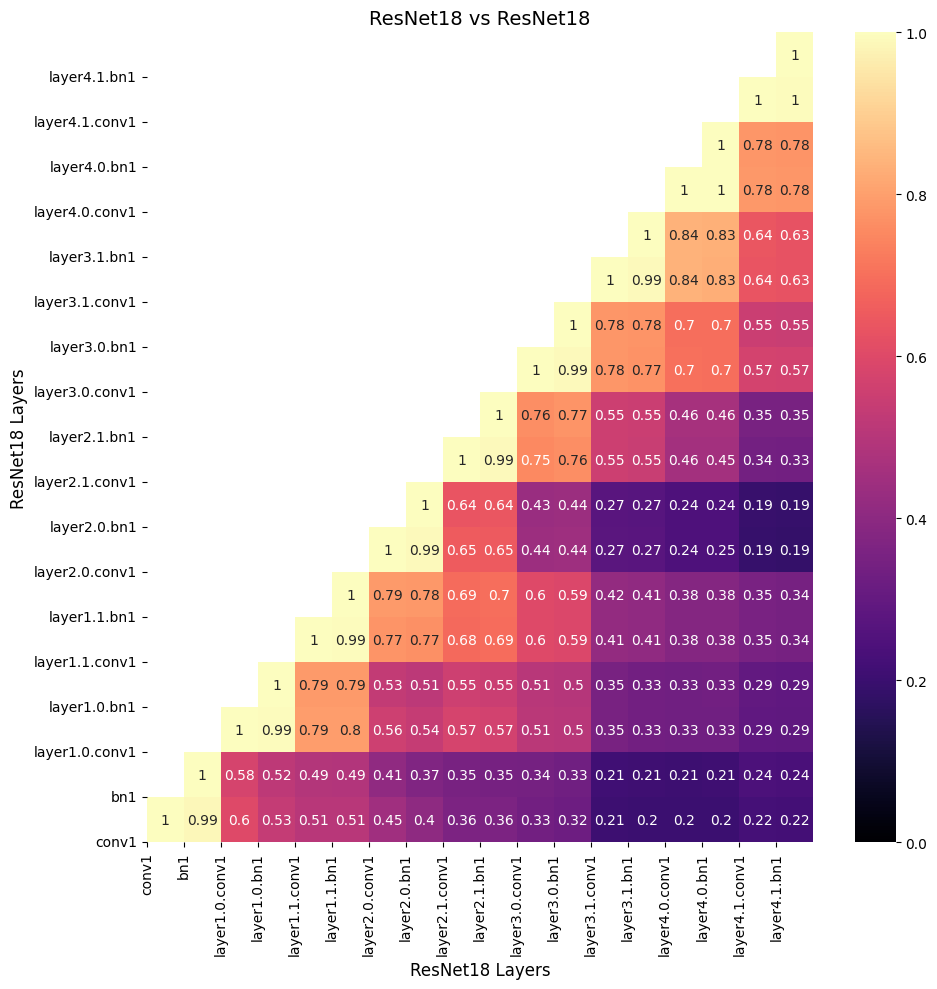

In [14]:
calculator.plot_cka_matrix(
    cka_output,
    show_half_heatmap=True,
    invert_y_axis=True,
    show_annotations=True,
)

In [15]:
calculator.reset()
torch.cuda.empty_cache()

### Non-recursive calculation

In [16]:
calculator = CKACalculator(
    model1=model1,
    model2=model2,
    model1_name="ResNet18",
    model2_name="ResNet18",
    batched_feature_size=256,
    verbose=True,
    hook_recursive=False,
)

In [17]:
cka_output = calculator.calculate_cka_matrix(dataloader)

Calculate CKA matrix (Epoch 1/10):   0%|          | 0/39 [00:00<?, ?it/s]/Users/datthinh1801/Code/CKA.pytorch/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Calculate CKA matrix (Epoch 10/10): 100%|██████████| 39/39 [00:26<00:00,  1.47it/s]


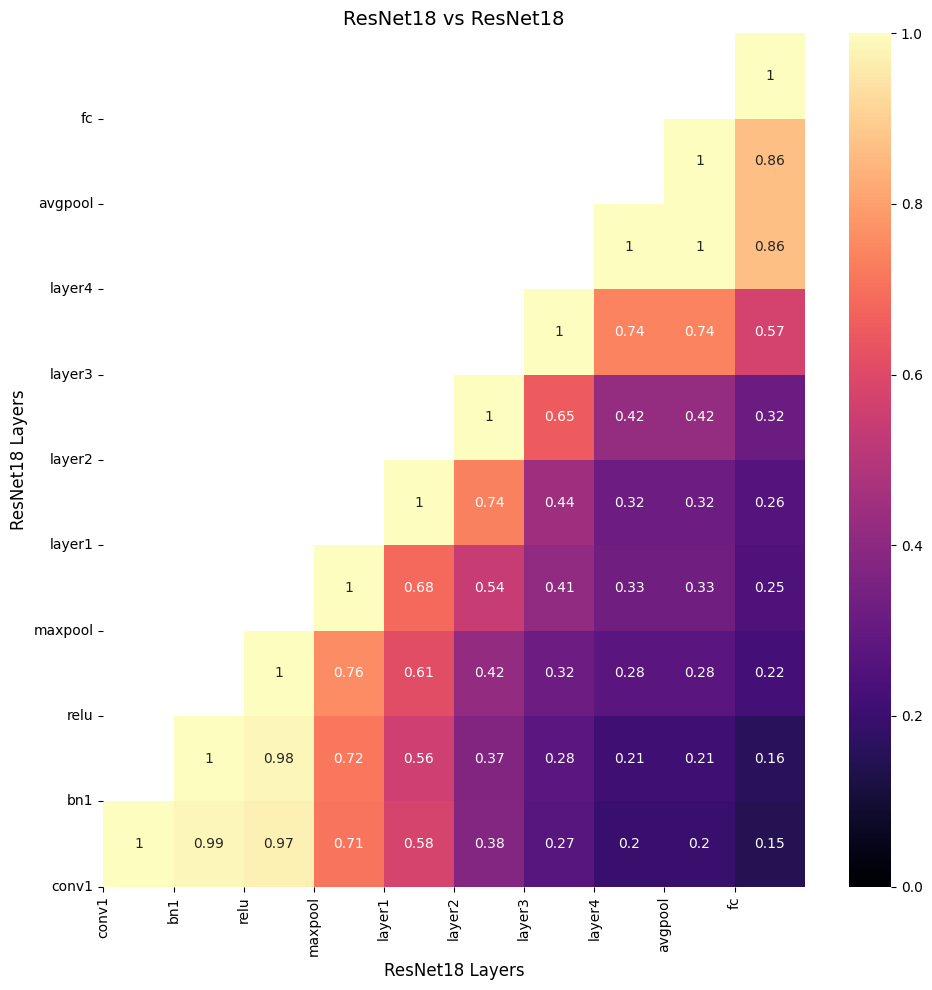

In [18]:
calculator.plot_cka_matrix(
    cka_output,
    show_half_heatmap=True,
    invert_y_axis=True,
    show_annotations=True,
)